# Holdout OOS Robustness

I want to see if profit factor or sharpe is a better indicator of a good trading strategy. I generate OOS trade stretegy returns given the prior that it has a certain sharpe. I wish to estimate the p-value that a strategy is not worthless.

In [36]:
import numpy as np
import pandas as pd
def generate_returns(n = 100000, sharpe = 0.3, annualized_ret = 0.2, normal = False):
    mean_return = annualized_ret / 365 #daily
    desired_std = mean_return/sharpe *np.sqrt(365)
    # returns = [np.random.standard_cauchy(1) for  _ in range(n)]
    if normal:
        # Generate normally distributed returns
        returns = np.random.normal(loc=mean_return, scale=desired_std, size=n)
    else:
        returns = np.random.standard_exponential(size=n)  # Generate Cauchy-distributed returns
        random_signs = np.random.choice([-1, 1], size=n)  # Randomly assign signs to returns
        returns *= random_signs  # Apply signs to returns
        returns_mean = np.mean(returns)
        returns_std = np.std(returns)
        # Adjust returns to achieve desired Sharpe ratio
        returns = [(r - returns_mean) / returns_std * desired_std + mean_return for r in returns]
    return pd.Series(returns)

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
def compare_sharpe_pf(n = 200000, generated_sharpe = 0.5, lookback = 365, return_ = False, normal = False):
    returns = generate_returns(n = n, sharpe = generated_sharpe, normal = normal)
    
    rolling_sharpe = returns.rolling(window=lookback).mean() / returns.rolling(window=lookback).std()*np.sqrt(365)
    Smean = rolling_sharpe[::lookback].mean()
    Sstd = rolling_sharpe[::lookback].std()
    
    rolling_pf = -((returns.where(returns > 0, 0)).rolling(window=lookback).sum())/((returns.where(returns < 0, 0)).rolling(window=lookback).sum())
    Pmean = rolling_pf[::lookback].mean()
    Pstd = rolling_pf[::lookback].std()
    if return_:
        return Smean, Sstd, Pmean, Pstd
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data = returns.cumsum(), label = 'Simulated Returns', ax= ax1)
    ax4 = fig.add_subplot(gs[0, 1])
    sns.histplot(returns, log_scale=(False,True), element = 'step', bins=50, ax=ax4)
    plt.title('Return Histogram')
    print('Sharpe Mean:', Smean)
    print('Sharpe Std:', Sstd)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.lineplot(data = rolling_sharpe, label = 'Rolling Sharpe Ratio', ax= ax2)
    print('Profit Factor Mean:', Pmean)
    print('Profit Factor Std:', Pstd)
    ax3 = fig.add_subplot(gs[1, 1])
    sns.lineplot(data = rolling_pf, label = 'Rolling Profit Factor', ax= ax3)
    plt.show()
    




Sharpe Mean: -0.03478217000673233
Sharpe Std: 0.9799613250455773
Profit Factor Mean: 1.0038433158756008
Profit Factor Std: 0.1300368050229572


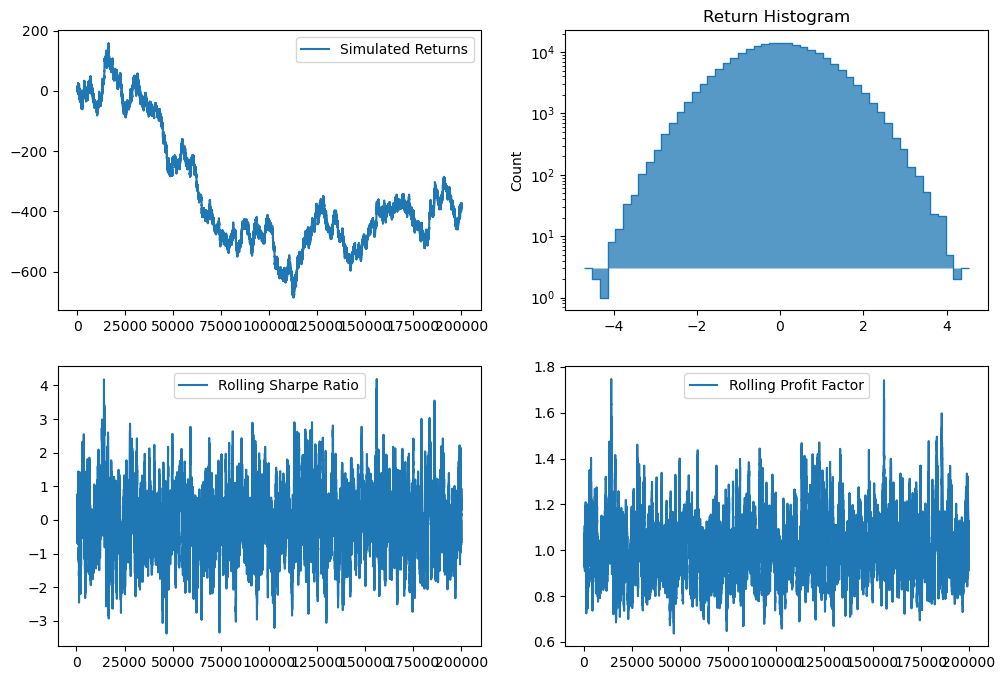

In [38]:
compare_sharpe_pf(n = 200000, generated_sharpe = 0.01, normal=True) # Example usage with a Sharpe ratio of 0.5

Sharpe Mean: 1.0426119397668132
Sharpe Std: 0.9539819378112299
Profit Factor Mean: 1.1559991643051204
Profit Factor Std: 0.14510205242436444


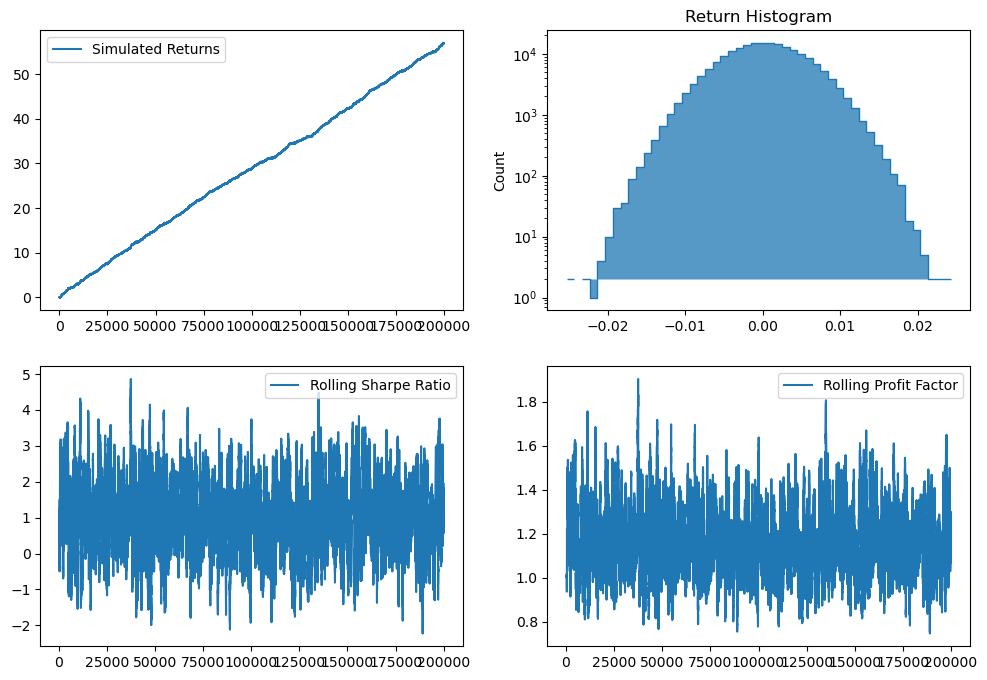

In [34]:
compare_sharpe_pf(generated_sharpe=1, normal=True)

The rolling PF seem to do just as good as Sharpe in a random Sharpe generated return. Now I will vary lookbacks

In [5]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf(n = 500000, generated_sharpe = 0.5, lookback = lookback, return_=True, normal=False) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
252,0.504,1.225,1.096,0.204
365,0.505,0.995,1.089,0.161
730,0.503,0.753,1.084,0.121
1095,0.501,0.548,1.081,0.088
1460,0.501,0.488,1.080,0.078
1825,0.499,0.471,1.079,0.076


In [39]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf(n = 500000, generated_sharpe = 0.5, lookback = lookback, return_=True, normal=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
252,0.524,1.217,1.085,0.175
365,0.523,0.996,1.080,0.143
730,0.472,0.702,1.069,0.099
1095,0.556,0.584,1.079,0.084
1460,0.481,0.455,1.067,0.063
1825,0.480,0.447,1.067,0.063


In [27]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf(n = 1000000, generated_sharpe = 0.2, lookback = lookback, return_=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
252,0.201,1.220,1.047,0.191
365,0.203,1.002,1.042,0.155
730,0.200,0.684,1.035,0.105
1095,0.200,0.581,1.034,0.089
1460,0.200,0.509,1.033,0.078
1825,0.198,0.442,1.032,0.068


In [28]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf(n = 1000000, generated_sharpe = 1, lookback = lookback, return_=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
252,1.009,1.237,1.181,0.218
365,1.007,0.987,1.173,0.172
730,1.002,0.714,1.166,0.124
1095,1.002,0.558,1.164,0.097
1460,1.001,0.493,1.163,0.085
1825,1.000,0.444,1.162,0.077


In [26]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf(n = 1000000, generated_sharpe = 1.5, lookback = lookback, return_=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
252,1.511,1.217,1.271,0.232
365,1.507,1.011,1.264,0.191
730,1.503,0.704,1.256,0.131
1095,1.503,0.588,1.253,0.108
1460,1.503,0.499,1.252,0.093
1825,1.501,0.448,1.251,0.083


Conclusion:
PF and Sharpe performs similarly, up to me which one to use. I read PF may be better in optimization, but Sharpe I think mimics real life more for walkthrough analysis.

If we backtest a daily strategy and get an annualized sharpe of 1, our 95% confidence interval has a lower bound of rougly 0 if our OOS data is 4-5 years long! For a strategy with OOS performance of 1.5 sharpe, we only need 3/4 of a year to the 95% confidence interval. The flipside is that even a worthless strategy can perform 1 sharpe 5% of the time with an OOS of 4-5 years.

For 1.5 sharpe, 2 years is enough.

Interestingly, the sharpe std stays constant between generated sharpes, which is important as to doesn't matter what our actual sharpe of the underlying strategy is which we won't know in real life. This means we can estimate a p-value reliably.



However, my estimates vary slightly depending on the distribution of the underlying returns. Using a normal distribution vs power law vs Pareto gives different numbers, so my conclusions should be taken with a grain of salt and used more as a hueristic. However, they are similar enough.

# Changing Granularity

Daily data really was a lot of OOS needed. More granularity means more data, maybe we thus need less days of data to be more confident. Lets test it!

In [10]:
import numpy as np
import pandas as pd
def generate_returns_hourly(n = 100000, sharpe = 0.3, annualized_ret = 0.1, normal = False):
    mean_return = annualized_ret / 365/24 #daily
    desired_std = mean_return/sharpe *np.sqrt(365*24)
    # returns = [np.random.standard_cauchy(1) for  _ in range(n)]
    if normal:
        # Generate normally distributed returns
        returns = np.random.normal(loc=mean_return, scale=desired_std, size=n)
    else:
        returns = np.random.standard_exponential(size=n)  # Generate Cauchy-distributed returns
        random_signs = np.random.choice([-1, 1], size=n)  # Randomly assign signs to returns
        returns *= random_signs  # Apply signs to returns
    returns_mean = np.mean(returns)
    returns_std = np.std(returns)
    # Adjust returns to achieve desired Sharpe ratio
    returns = [(r - returns_mean) / returns_std * desired_std + mean_return for r in returns]
    return pd.Series(returns)

def compare_sharpe_pf_hourly(n = 200000, generated_sharpe = 0.5, lookback = 365*24, return_ = False, normal = False):
    returns = generate_returns_hourly(n = n, sharpe = generated_sharpe, normal = normal)
    
    rolling_sharpe = returns.rolling(window=lookback).mean() / returns.rolling(window=lookback).std()*np.sqrt(365*24)
    Smean = rolling_sharpe[::lookback].mean()
    Sstd = rolling_sharpe[::lookback].std()
    
    rolling_pf = -((returns.where(returns > 0, 0)).rolling(window=lookback).sum())/((returns.where(returns < 0, 0)).rolling(window=lookback).sum())
    Pmean = rolling_pf[::lookback].mean()
    Pstd = rolling_pf[::lookback].std()
    if return_:
        return Smean, Sstd, Pmean, Pstd
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data = returns.cumsum(), label = 'Simulated Returns', ax= ax1)
    ax4 = fig.add_subplot(gs[0, 1])
    sns.histplot(returns, log_scale=(False,True), element = 'step', bins=50, ax=ax4)
    plt.title('Return Histogram')
    print('Sharpe Mean:', Smean)
    print('Sharpe Std:', Sstd)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.lineplot(data = rolling_sharpe, label = 'Rolling Sharpe Ratio', ax= ax2)
    print('Profit Factor Mean:', Pmean)
    print('Profit Factor Std:', Pstd)
    ax3 = fig.add_subplot(gs[1, 1])
    sns.lineplot(data = rolling_pf, label = 'Rolling Profit Factor', ax= ax3)
    plt.show()
    




Sharpe Mean: 0.5008991648602191
Sharpe Std: 1.0577794693203653
Profit Factor Mean: 1.0157417945252287
Profit Factor Std: 0.03238211932534343


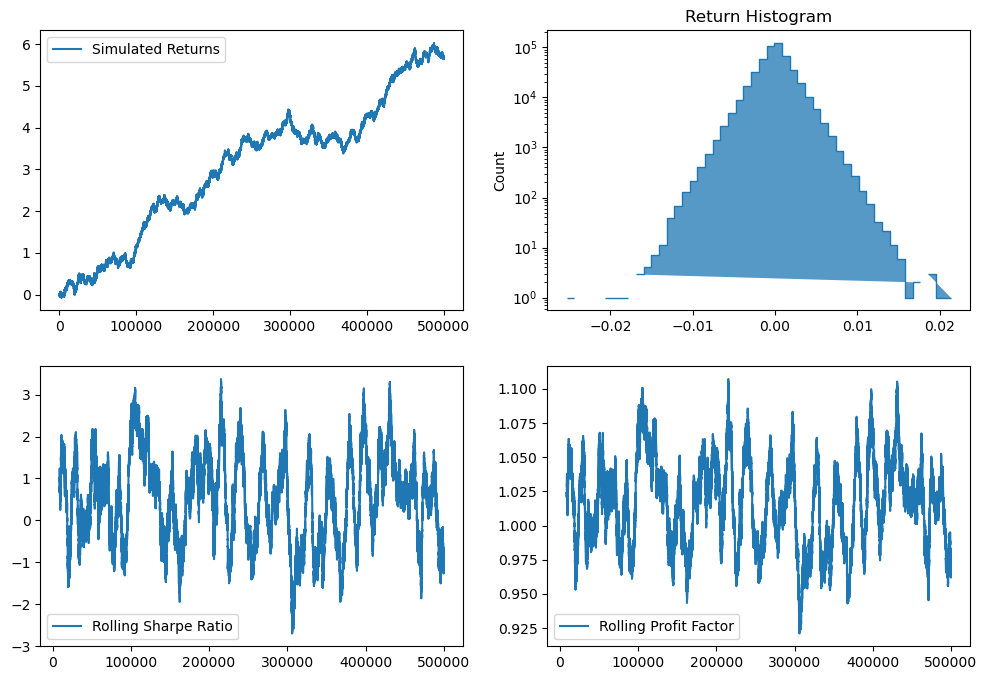

In [11]:
compare_sharpe_pf_hourly(n = 500000, generated_sharpe = 0.5) # Example usage with a Sharpe ratio of 0.5

In [22]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]
lookback_arr = [lookback * 24 for lookback in lookback_arr]  # Convert to hourly lookbacks

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf_hourly(n = 10000000, generated_sharpe = 1.5, lookback = lookback, return_=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
6048,1.499,1.229,1.047,0.039
8760,1.501,0.991,1.047,0.031
17520,1.500,0.715,1.047,0.023
26280,1.499,0.561,1.046,0.018
35040,1.499,0.499,1.046,0.016
43800,1.498,0.446,1.046,0.014


In [23]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]
lookback_arr = [lookback * 24 for lookback in lookback_arr]  # Convert to hourly lookbacks

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf_hourly(n = 10000000, generated_sharpe = 1.5, lookback = lookback, return_=True, normal=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
6048,1.500,1.215,1.042,0.034
8760,1.500,0.993,1.041,0.028
17520,1.500,0.710,1.041,0.020
26280,1.501,0.563,1.041,0.016
35040,1.499,0.511,1.041,0.014
43800,1.499,0.489,1.041,0.014


In [29]:
lookback_arr = [252, 365, 365*2, 365*3, 365*4, 365*5]
lookback_arr = [lookback * 24 for lookback in lookback_arr]  # Convert to hourly lookbacks

result = {}
for lookback in lookback_arr:
    smean, sstd, pmean,pstd = compare_sharpe_pf_hourly(n = 20000000, generated_sharpe = 1, lookback = lookback, return_=True) # Example usage with a Sharpe ratio of 0.5
    result[lookback] = np.round([smean, sstd, pmean, pstd],3)
result_df = pd.DataFrame(result, index=['Sharpe Mean', 'Sharpe Std', 'Profit Factor Mean', 'Profit Factor Std']).T
result_df.index.name = 'Lookback Days'
result_df.columns.name = 'Metrics'
result_df

Metrics,Sharpe Mean,Sharpe Std,Profit Factor Mean,Profit Factor Std
Lookback Days,,,,
6048,1.000,1.213,1.031,0.038
8760,1.001,0.983,1.031,0.031
17520,1.000,0.681,1.031,0.021
26280,1.000,0.592,1.031,0.018
35040,0.999,0.499,1.031,0.016
43800,0.999,0.439,1.031,0.014


These numbers are very similar for low granularity, so have more information about returns in a granlularity context is not moticable helping

In [44]:
np.sqrt((1+1**2/(365))/4)

0.5006844630172274

# Conclusion:

Doesn't matter the return distribution or granularity you are trading at, if your annualized sharpe ratio for whatever your maker is in is held constrant, you you estimate the number of years of OOS data that you need.

Here are the corresponding Sharpe std deviations to construct confidence intervals by length of OOS period.
 - 252 days: 1.21
 - 1 years: .98
 - 2 years: 0.70
 - 3 years: 0.58
 - 4 years: 0.50
 - 5 years: 0.44

 These results are consistent with Lo's paper, where the estimated sharpe ratio converges to N(SR, (1+SR**2/(2q))/y), where q is the number of returns a year and y is the number of years used to estimate.

 These are rough empirical estimates based on the code above.

 eg. if you run your strategy on a sample OOS for 2 years with a sharpe of 1.4, your confidence interval would have a lower bound of 0.

### Weaknesses of this experiment

1. We are assuming strategy returns are not correlated for power law dist. Here this is not the case as my generation fixes return mean, which leaks future information through mean reversion. Lower returns are more likely to be followed by higher means.
- Changing normal to be truly random we get similar results



### How to use these results

We don't need to use OOS in order to use these results.

Consider the situation that we make an strategy with an IS Sharpe of 1.5 over many years. Even if it performs this well out of sample, can we be sure that it is a good sample? The answer is no, even if we don't know how well it performs out of sample. Therefore, we can set a minimum IS requirement of at least 2 if we are holding out 1 year of data and so on.

If we use our OOS more than one in case we are not happy with our results, we will also need to account for the chance that of we were to have n worthless strategies, the probability that at least one would perform just as well as our strategy. Therefore, each time we test a strategy, we just be very careful as our sharpe needed in order to be happy enough for live trading will increase accordingly.

We also know that the IS has inherent bias, where that is data mining or the inherent structure of the model that we are using. We can use other measures in order to determine ourselves what our unbiased sharpe truly may be.